"Predict the fare amount of future rides using regression analysis: Uber"

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Parameters for synthetic data generation
num_rides = 1000
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 2, 1)

# Generate random timestamps
def random_date(start, end):
    return start + timedelta(seconds=random.randint(0, int((end - start).total_seconds())))

# Generate random latitude and longitude coordinates
def random_coordinates():
    lat = random.uniform(40.5, 41.0)  # Roughly NYC area
    lon = random.uniform(-74.0, -73.5)
    return lat, lon

# Haversine distance formula to calculate distance between two lat/lon coordinates
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

# Generate synthetic data
data = []

for _ in range(num_rides):
    pickup_lat, pickup_lon = random_coordinates()
    dropoff_lat, dropoff_lon = random_coordinates()
    distance = haversine_distance(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon)

    # Generate a random date and time within the range
    pickup_time = random_date(start_date, end_date)

    # Calculate fare (simple model: base fare + distance * rate)
    base_fare = 2.50
    rate_per_km = 1.25
    fare = round(base_fare + distance * rate_per_km, 2)

    data.append([pickup_time, pickup_lat, pickup_lon, dropoff_lat, dropoff_lon, distance, fare])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'distance_km', 'fare_amount'])

# Save to CSV
df.to_csv('uber_rides.csv', index=False)

print("Synthetic Uber rides data generated and saved as 'uber_rides.csv'.")


Synthetic Uber rides data generated and saved as 'uber_rides.csv'.


Mean Absolute Error: 0.0026257702015002014
Mean Squared Error: 8.809016293257066e-06
R-squared: 0.9999999635394539


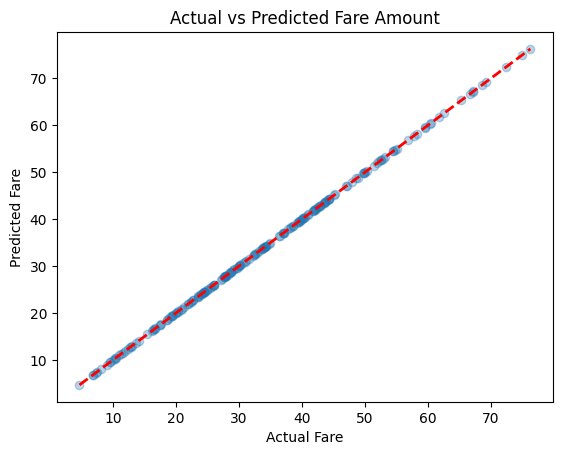

In [4]:
!pip install pandas numpy scikit-learn matplotlib seaborn jupyter

# uber_fare_prediction.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load the data
def load_data(file_path):
    return pd.read_csv(file_path)

# 2. Data Cleaning
def clean_data(df):
    # Drop rows with missing fare amount
    df = df.dropna(subset=['fare_amount'])
    # Remove rows with unreasonable fare amount
    df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 500)]
    # Remove rows with unreasonable coordinates
    df = df[(df['pickup_latitude'] > -90) & (df['pickup_latitude'] < 90)]
    df = df[(df['pickup_longitude'] > -180) & (df['pickup_longitude'] < 180)]
    df = df[(df['dropoff_latitude'] > -90) & (df['dropoff_latitude'] < 90)]
    df = df[(df['dropoff_longitude'] > -180) & (df['dropoff_longitude'] < 180)]
    return df

# 3. Feature Engineering
def haversine_distance(lat1, lon1, lat2, lon2):
    # Calculate distance between two coordinates using the Haversine formula
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    return R * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

def feature_engineering(df):
    df['distance_km'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'],
                                           df['dropoff_latitude'], df['dropoff_longitude'])
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    return df[['fare_amount', 'distance_km', 'hour']]

# 4. Train-Test Split
def split_data(df):
    X = df[['distance_km', 'hour']]
    y = df['fare_amount']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model Training
def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

# 6. Model Evaluation
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mae, mse, r2, predictions

# 7. Visualization
def visualize_results(y_test, predictions):
    plt.scatter(y_test, predictions, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
    plt.xlabel('Actual Fare')
    plt.ylabel('Predicted Fare')
    plt.title('Actual vs Predicted Fare Amount')
    plt.show()

# 8. Main function
def main():
    # Load data
    df = load_data('uber_rides.csv')

    # Clean data
    df = clean_data(df)

    # Feature engineering
    df = feature_engineering(df)

    # Split data
    X_train, X_test, y_train, y_test = split_data(df)

    # Train model
    model = train_model(X_train, y_train)

    # Evaluate model
    mae, mse, r2, predictions = evaluate_model(model, X_test, y_test)
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Visualize results
    visualize_results(y_test, predictions)

if __name__ == "__main__":
    main()